In [21]:
import json
import torch
import pickle

from CrossModalGraphFormer import CMGFormer
from easydict import EasyDict

torch.manual_seed(128)

data = '/home/drew/Desktop/Research/MMSA/datasets/CMU-MOSI/Processed/unaligned_50.pkl'
weights = '/home/drew/Desktop/Research/MMSA/saved_models/cmgformer-mosi.pth'
cfg_path = "/home/drew/Desktop/Research/MMSA/src/MMSA/models/custom/cfg.json"
with open(cfg_path) as f:
    cfg = EasyDict(json.load(f)['mosi'])
with open(data, 'rb') as f:
    data = pickle.load(f)
model = CMGFormer(cfg)
weight_pth = torch.load(weights)
for k in list(weight_pth.keys()):  # 使用list()来避免在迭代中修改字典
    if k.startswith('Model.'):
        new_k = k[6:]  
        weight_pth[new_k] = weight_pth.pop(k)  # 重命名权重
model.load_state_dict(weight_pth)

<All keys matched successfully>

In [22]:
train, val, test = data.values()
train.keys()

chosen_clip = 0
text = torch.from_numpy(train['text_bert'][chosen_clip]).unsqueeze(0)
input_ids, input_mask, segment_ids = text[:,0,:].long(), text[:,1,:].float(), text[:,2,:].long()
vision = torch.from_numpy(train['vision'][chosen_clip]).to(torch.float32).unsqueeze(0)
vision_length = torch.tensor(train['vision_lengths'][chosen_clip]).unsqueeze(0)
audio = torch.from_numpy(train['audio'][chosen_clip]).to(torch.float32).unsqueeze(0)
audio_length = torch.tensor(train['audio_lengths'][chosen_clip]).unsqueeze(0)
train['id'][chosen_clip], train['raw_text'][chosen_clip]

('03bSnISJMiM$_$11', 'A LOT OF SAD PARTS')

In [23]:
with torch.no_grad():
    res, output, split = model(
        (input_ids, input_mask, segment_ids),
        (audio, audio_length),
        (vision, vision_length),
        plt = True
    )
(nd_f_w, d_f_w), (nd_b_w, d_b_w), (nd_s_w, d_s_w) = output.weights

In [24]:
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
def transform_np(input):    
    return input.clone()[0].detach().to('cpu')
plt_arr = [np.array(transform_np(m)) for m in [nd_f_w, nd_b_w, nd_s_w]]

In [26]:
t, v, a = split
s1 = (0, t)                 # [0, t)
s2 = (t, t + v)             # [t, t + v)
s3 = (t + v, t + v + a)     # [t + v, t + v + a)

In [27]:
tl, vl, al = int(torch.sum(input_mask)), int(vision_length), int(audio_length)
tl, vl, al

(7, 26, 22)

In [28]:
def split_mat(mat, row, col, first, second):
    return mat[row[0]:row[0]+first, col[0]:col[0]+second]

# forward
v2t = split_mat(plt_arr[0], s1, s2, tl, vl)
a2v = split_mat(plt_arr[0], s2, s3, vl, al)
t2a = split_mat(plt_arr[0], s3, s1, al, tl)

# backward
a2t = split_mat(plt_arr[1], s1, s3, tl, al)
t2v = split_mat(plt_arr[1], s2, s1, vl, tl)
v2a = split_mat(plt_arr[1], s3, s2, al, vl)

# self
t2t = split_mat(plt_arr[2], s1, s1, tl, tl)
v2v = split_mat(plt_arr[2], s2, s2, vl, vl)
a2a = split_mat(plt_arr[2], s3, s3, al, al)

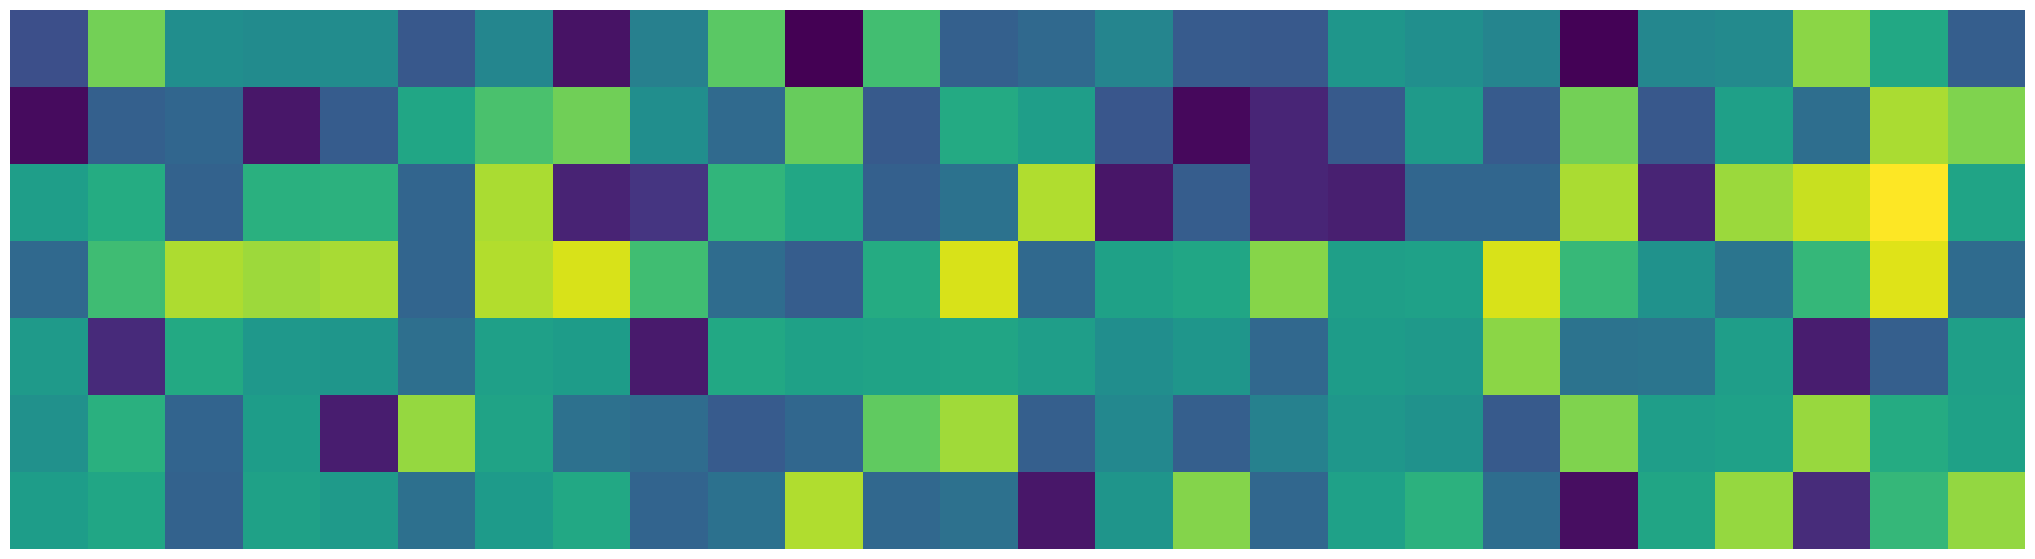

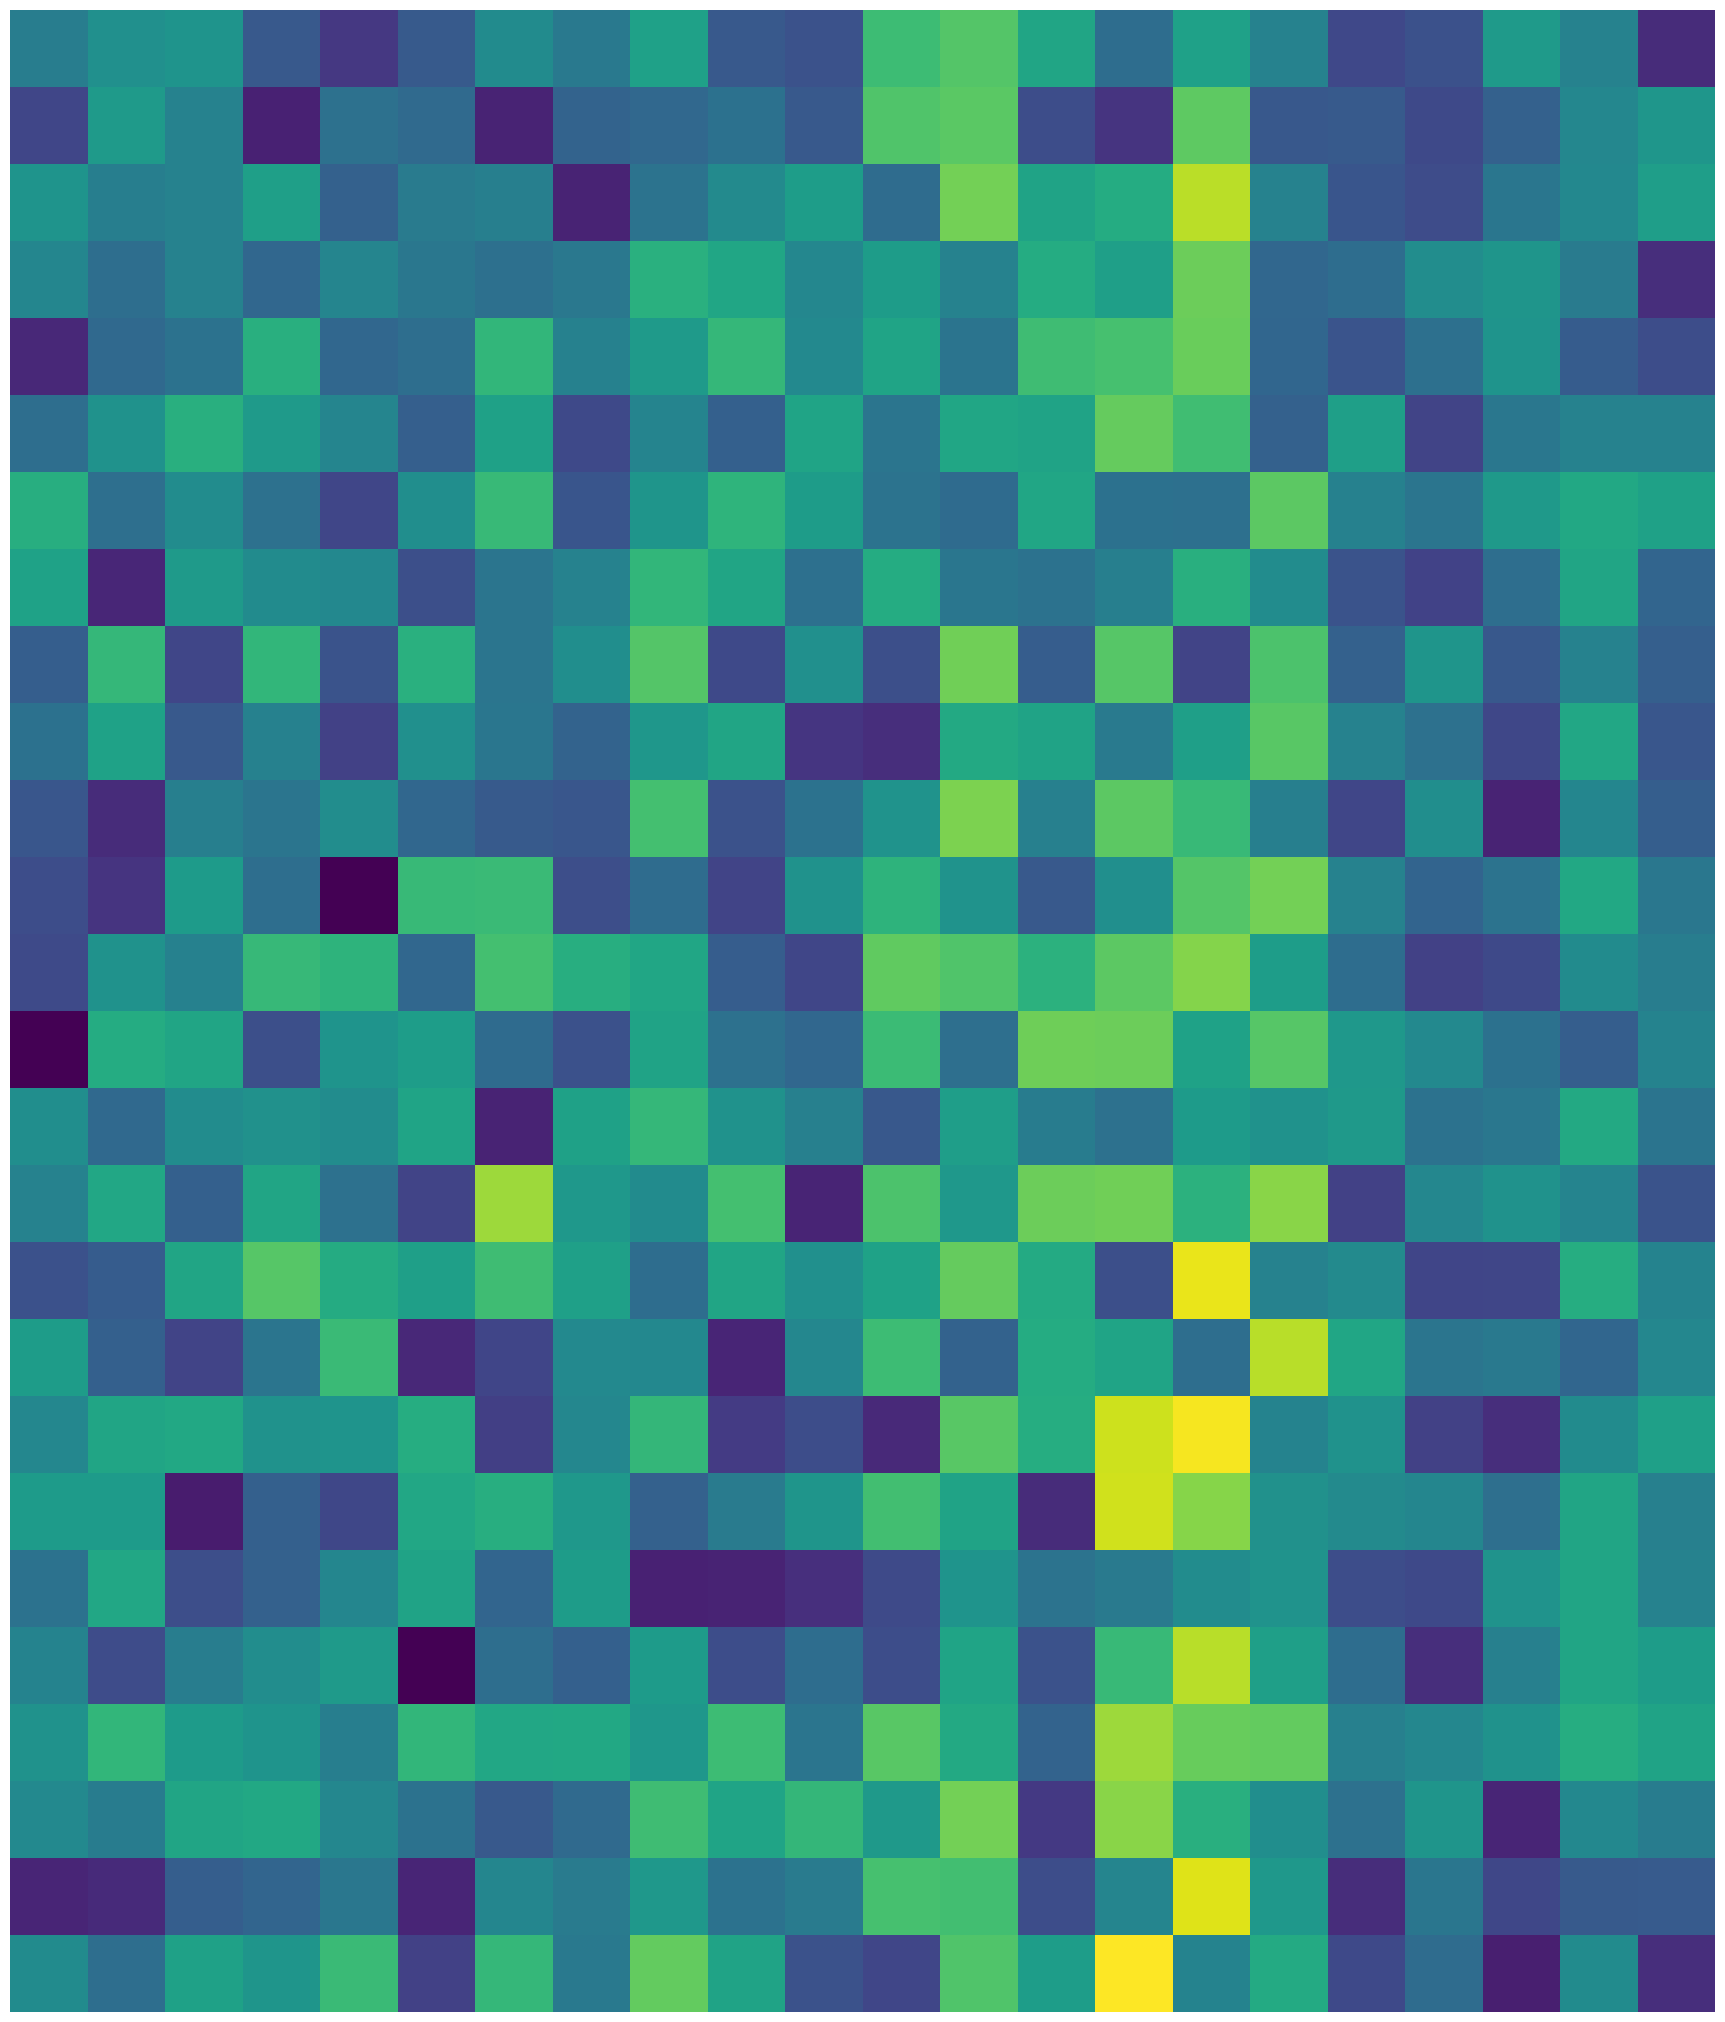

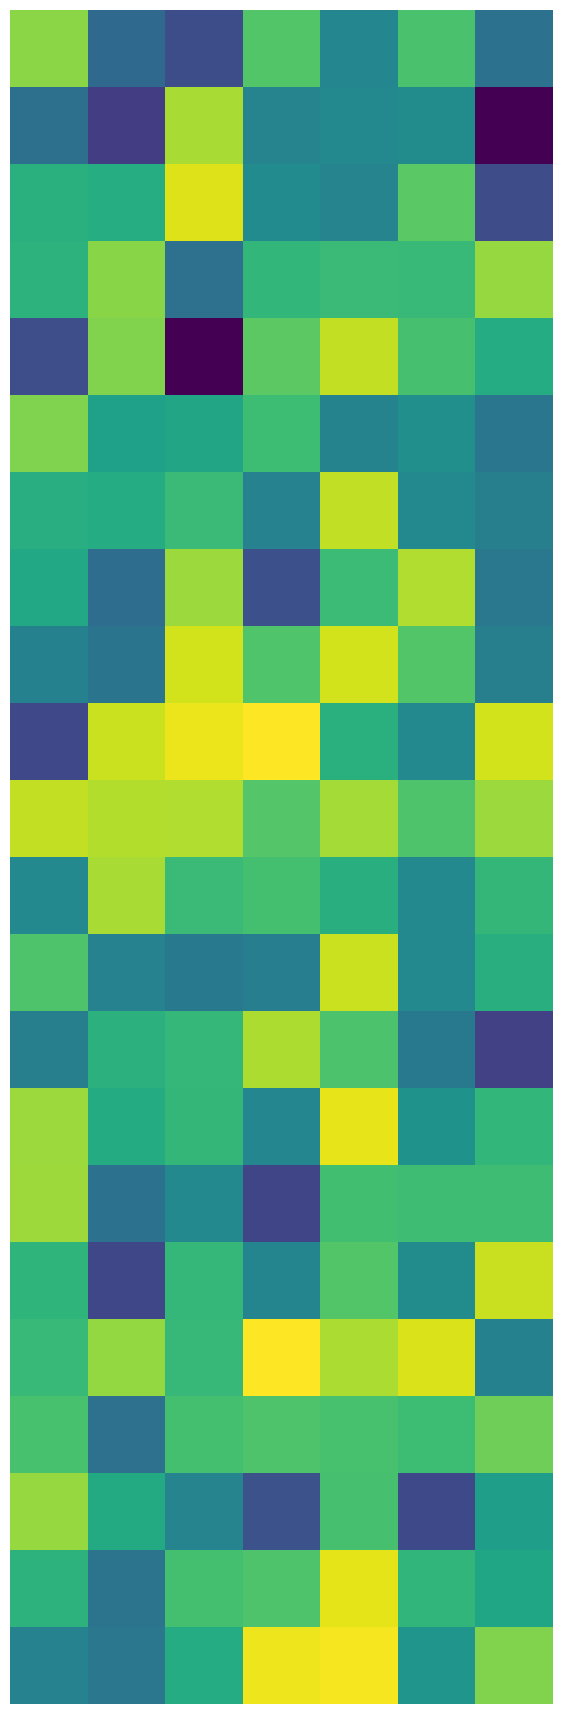

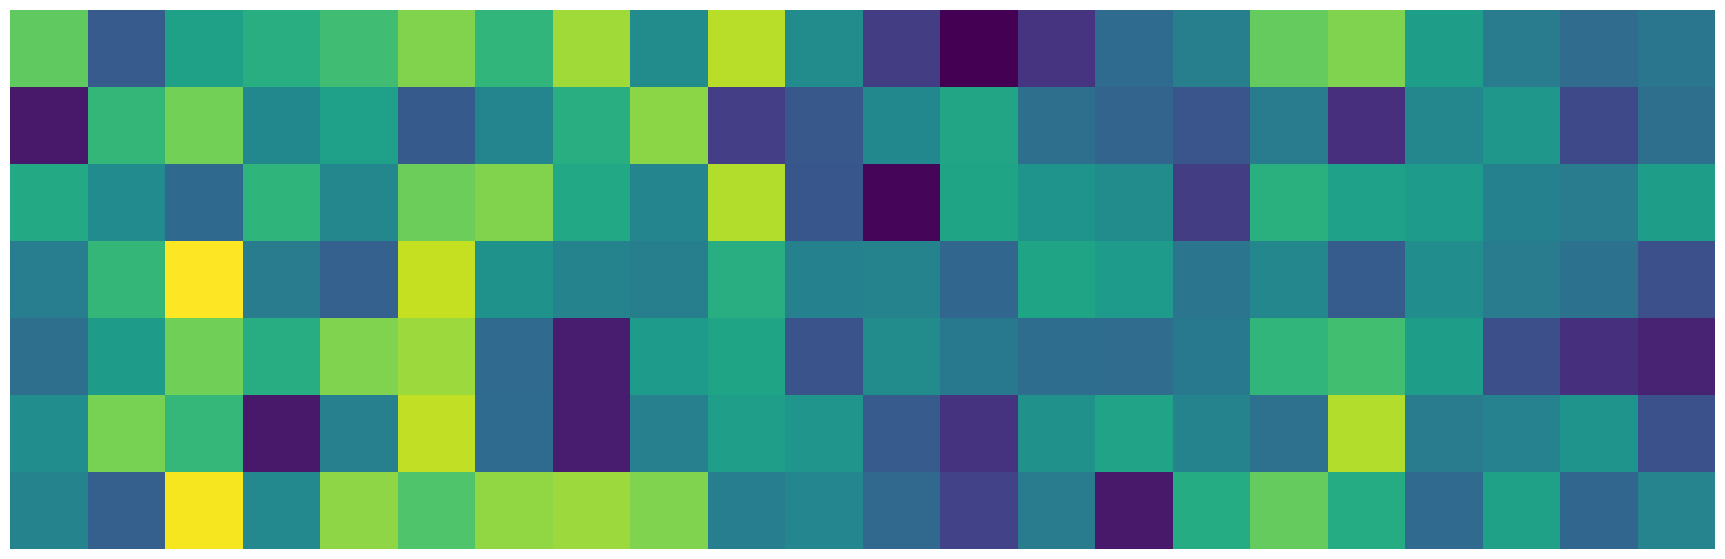

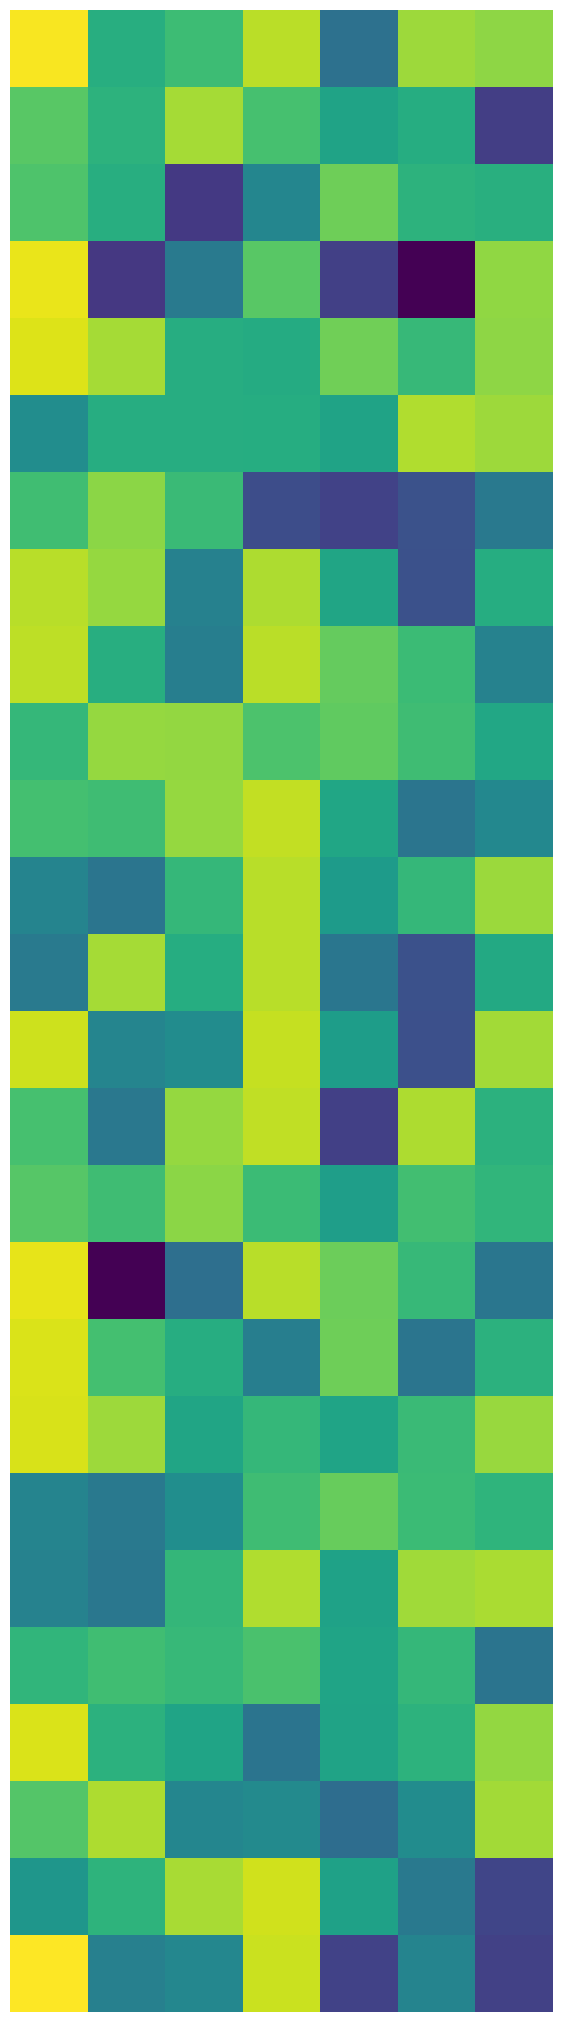

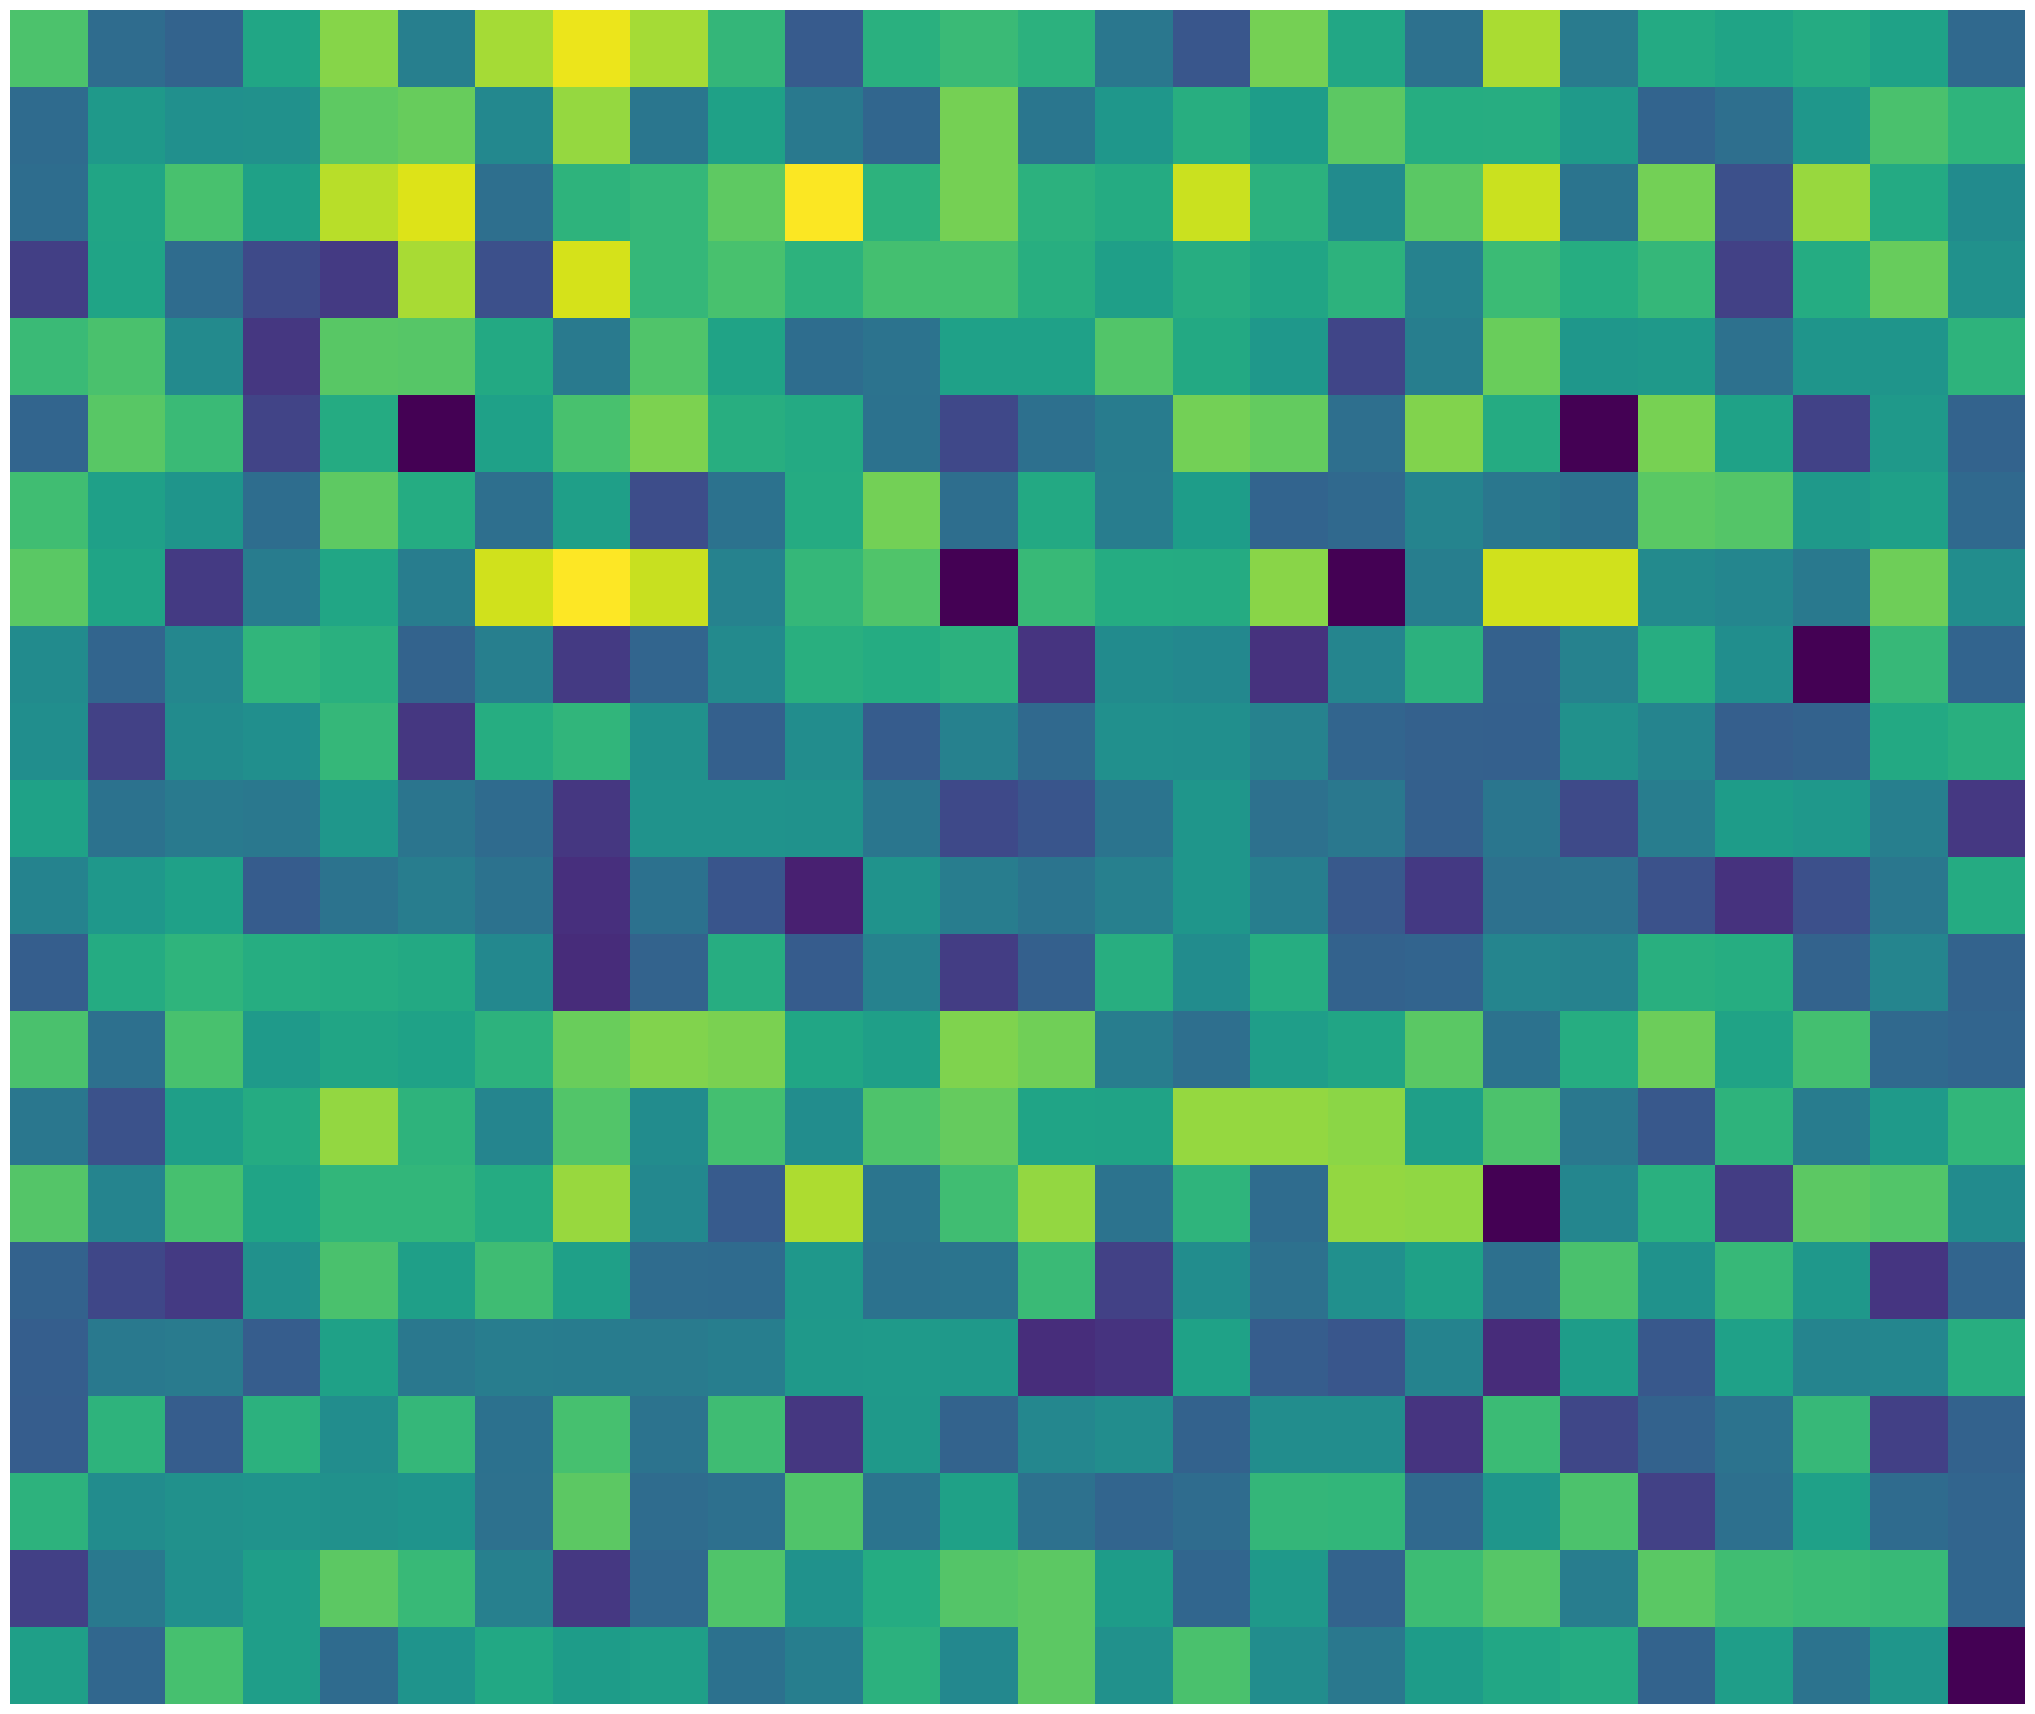

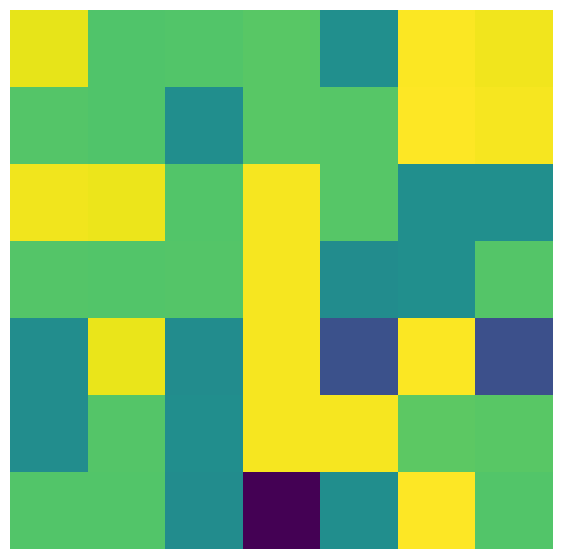

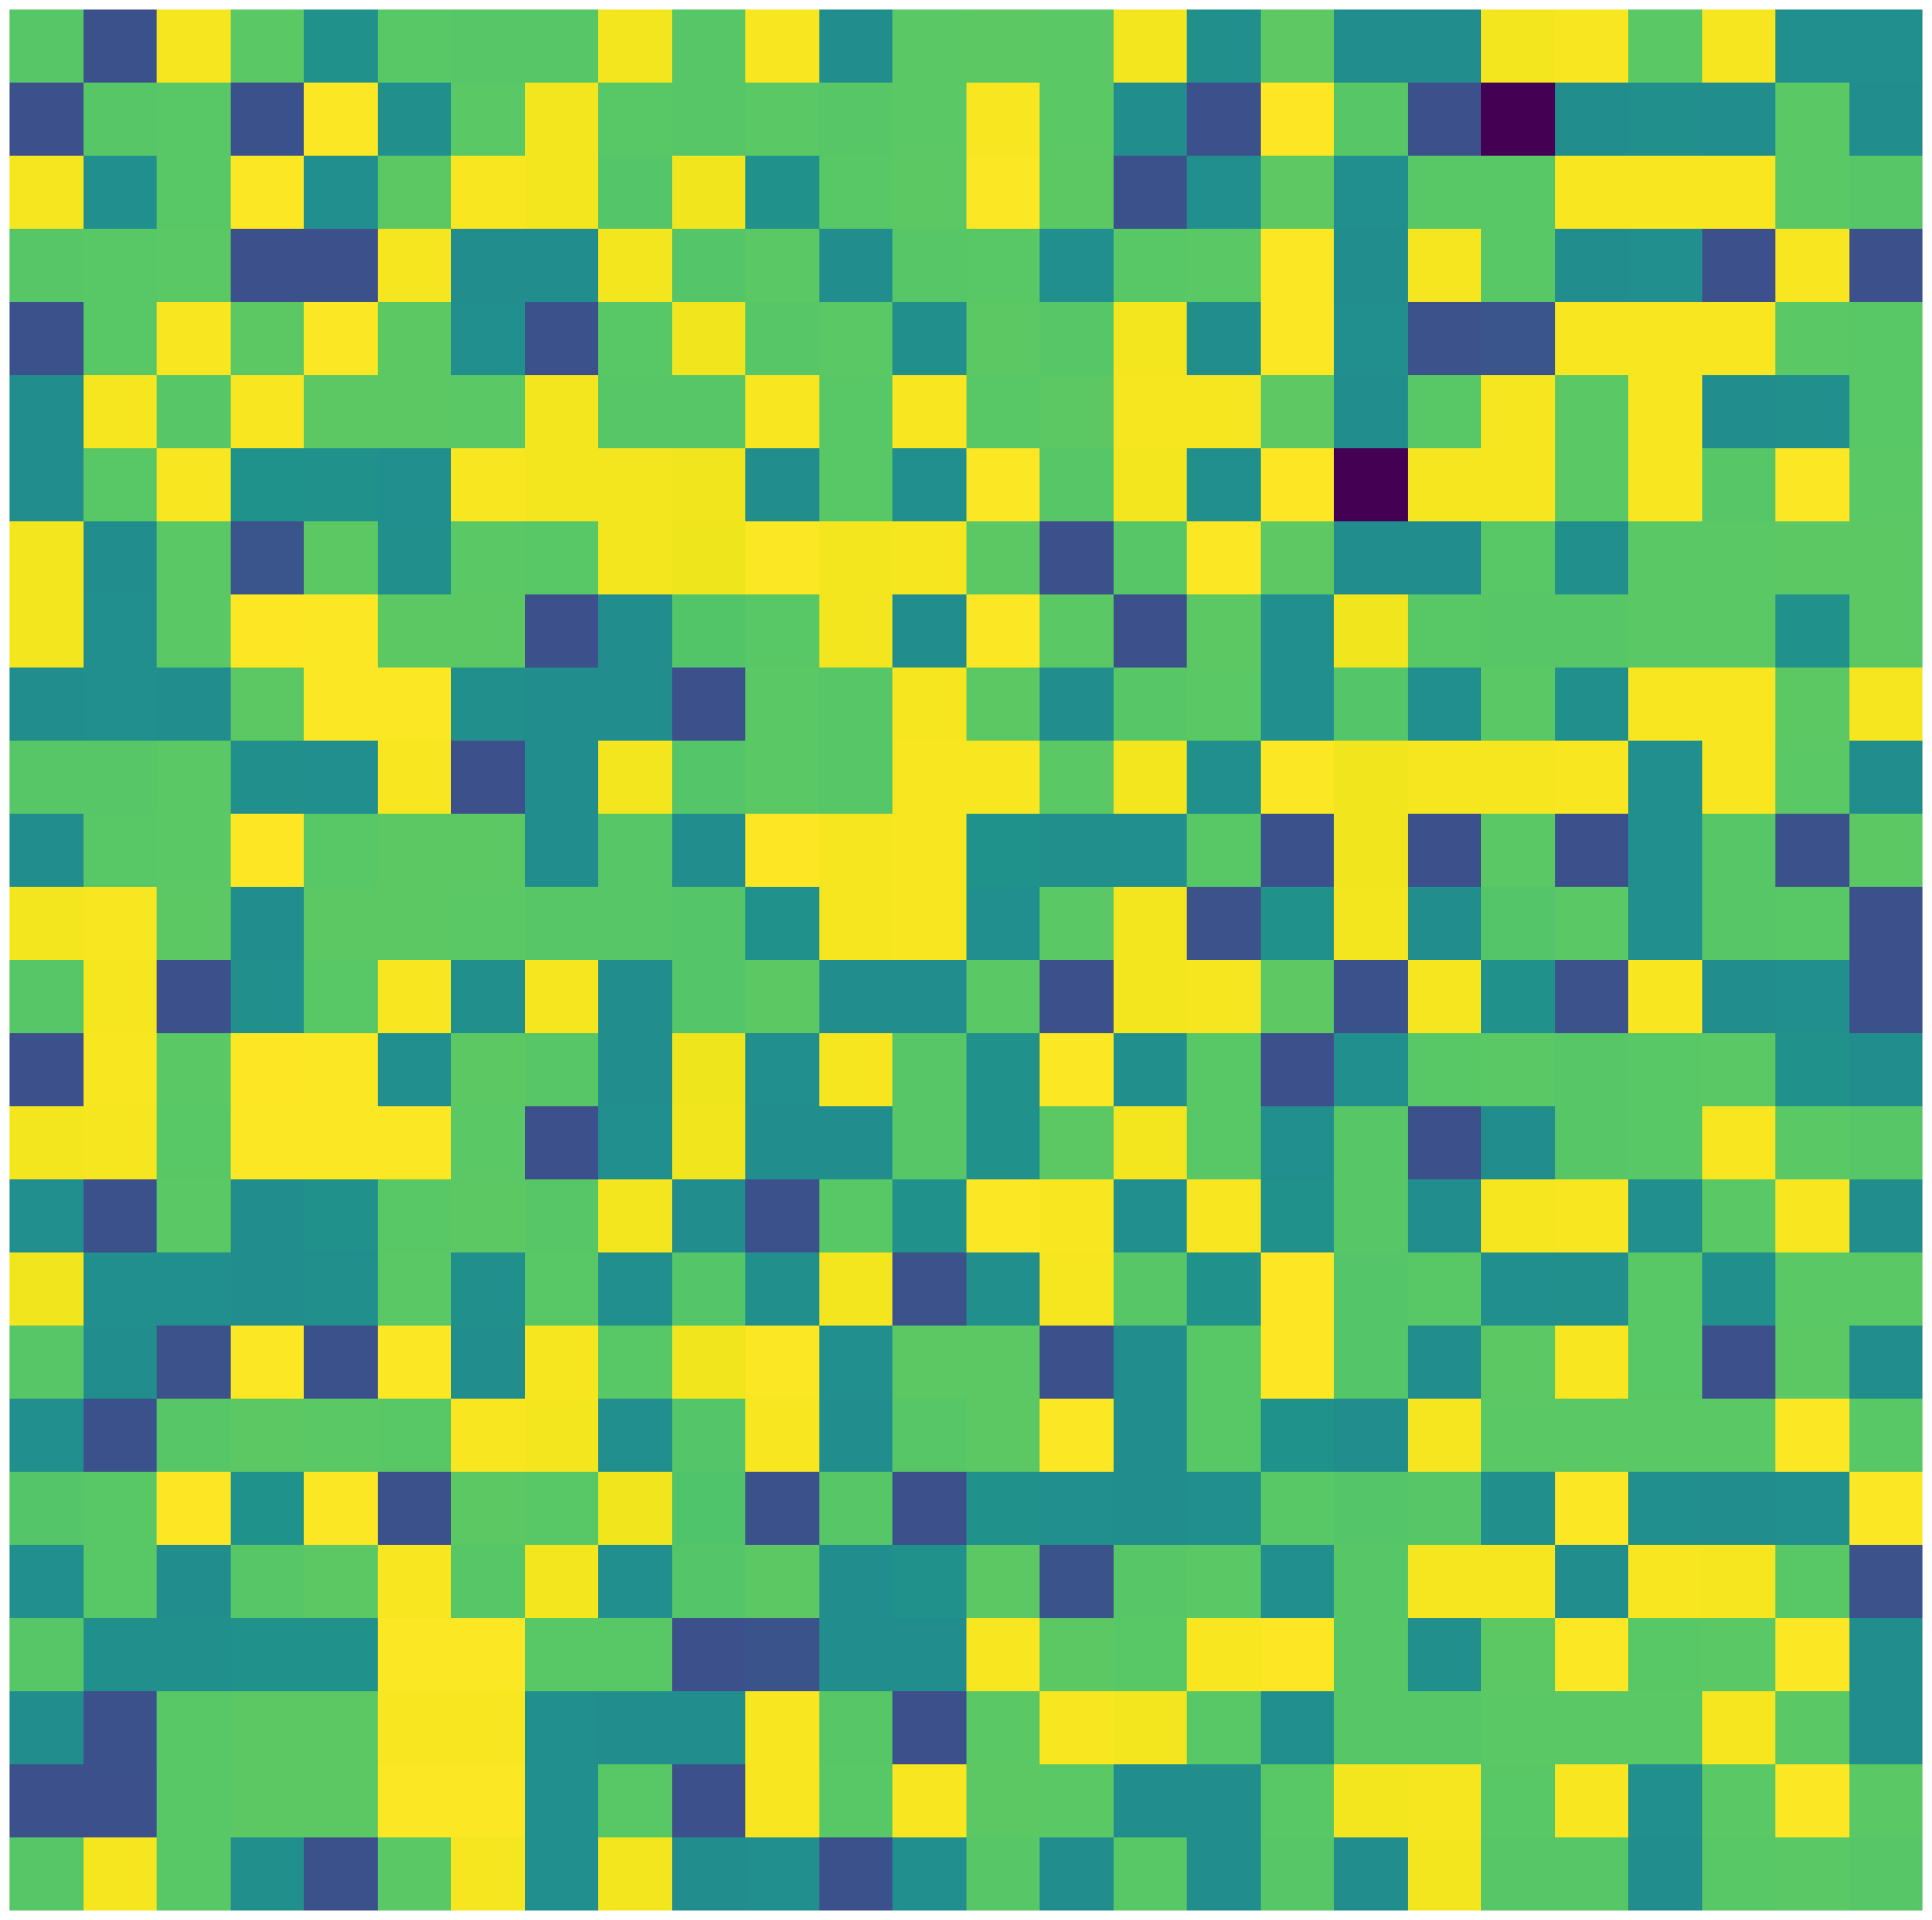

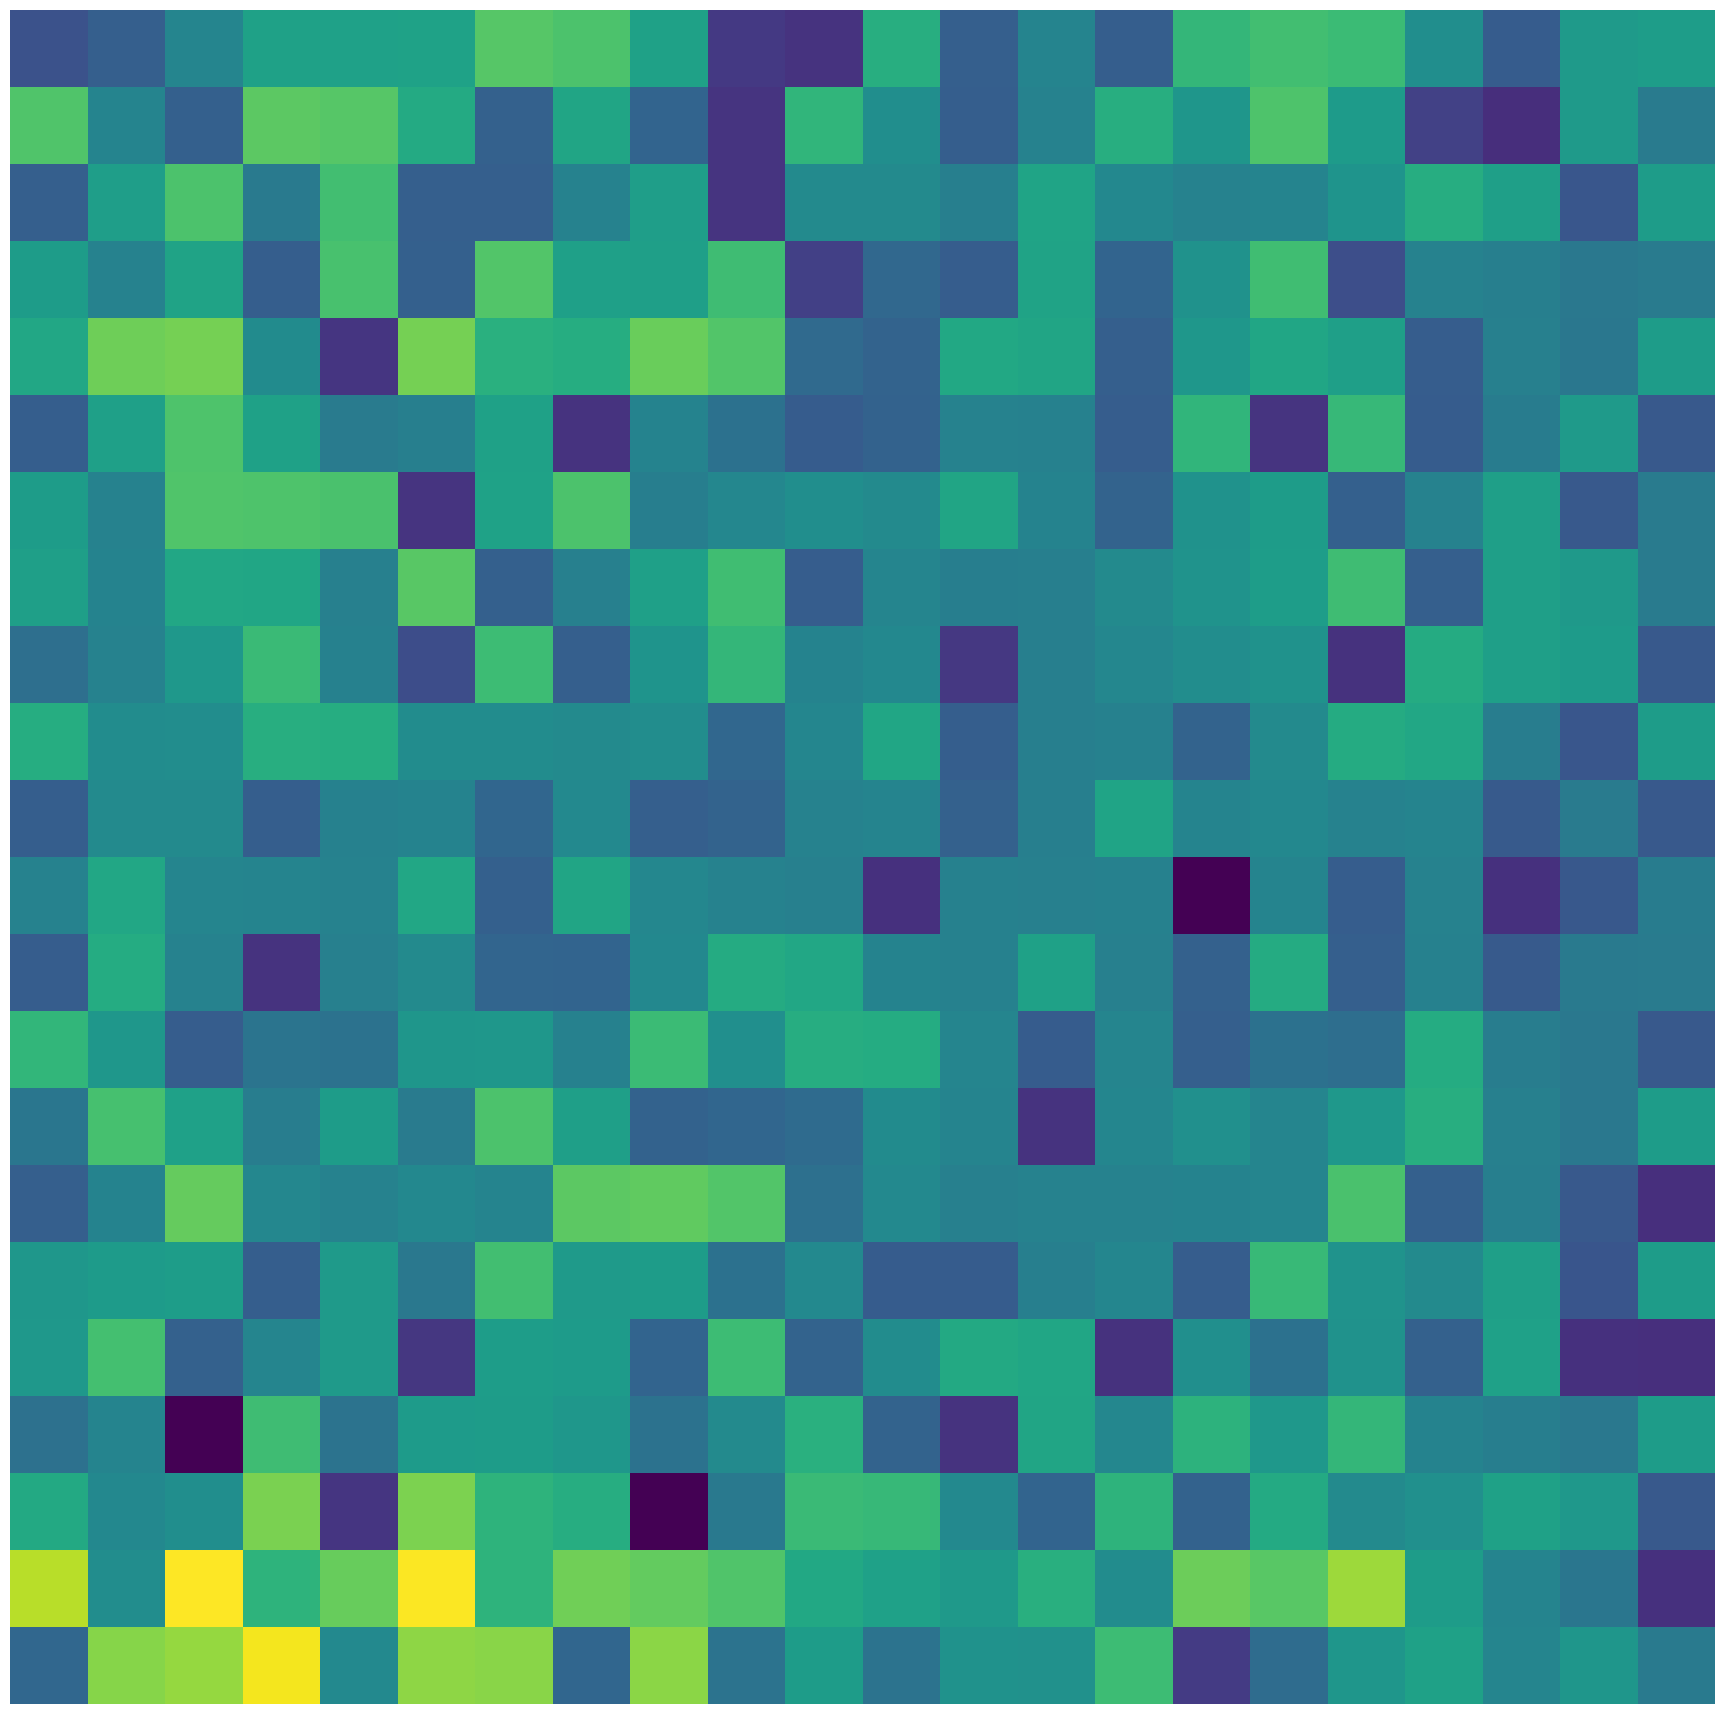

In [29]:
# 绘制三个子图，1行3列
for idx, data in enumerate([v2t,a2v,t2a,a2t,t2v,v2a,t2t,v2v,a2a]):
    first, second = data.shape
    plt.figure(figsize=(second, first))  # 可以调整图形的大小
    sns.heatmap(data, cmap='viridis', xticklabels=False, yticklabels=False, annot=False, cbar=False)
    plt.tick_params(axis='x', which='both', length=0)
    plt.tick_params(axis='y', which='both', length=0)
    plt.savefig(f'/home/drew/Desktop/Research/MMSA/src/MMSA/models/custom/CrossModalGraphFormer/fig/{idx}.png')

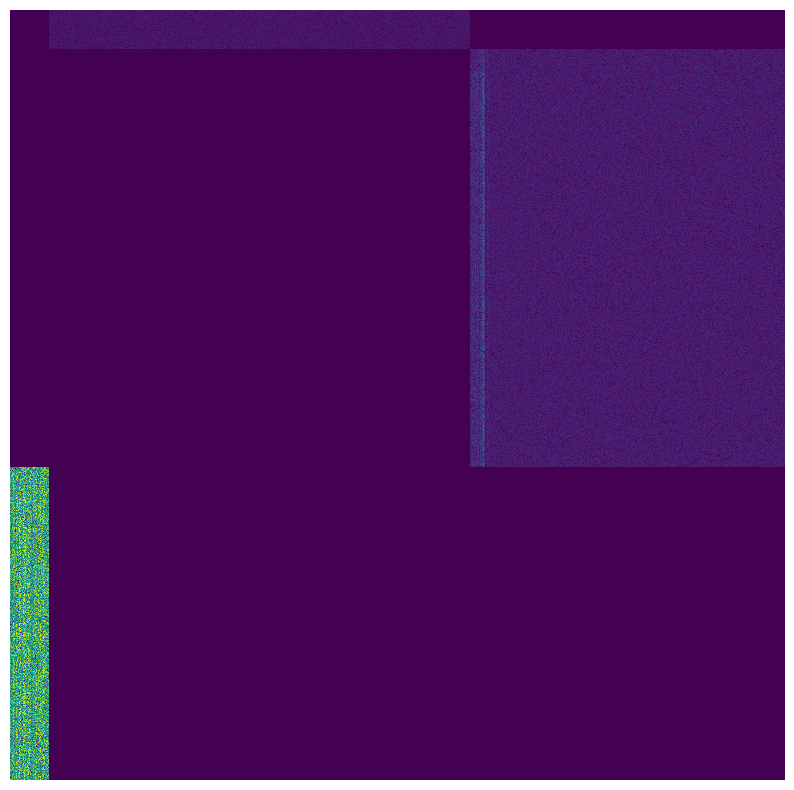

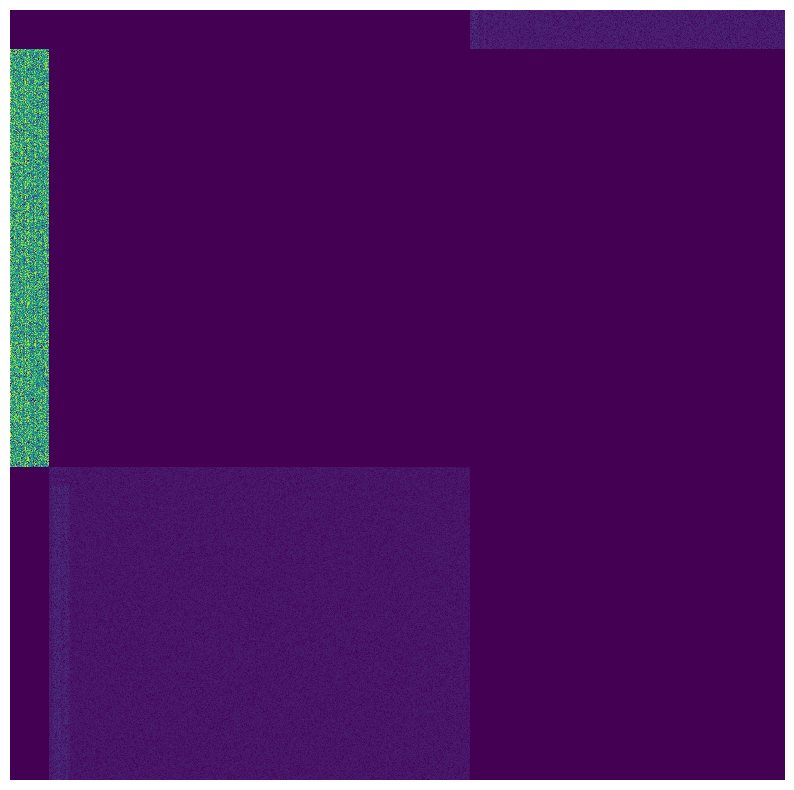

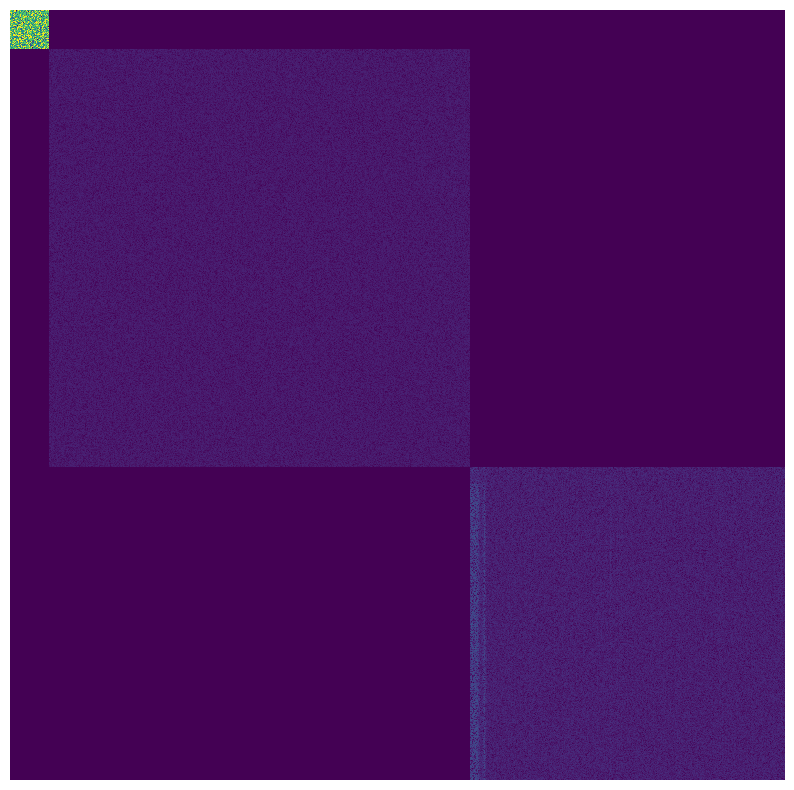

In [30]:
for data in plt_arr:
    first, second = data.shape
    plt.figure(figsize=(10, 10))  # 可以调整图形的大小
    sns.heatmap(data, cmap='viridis', xticklabels=False, yticklabels=False, annot=False, cbar=False)
    plt.tick_params(axis='x', which='both', length=0)
    plt.tick_params(axis='y', which='both', length=0)
    plt.show()